In [1]:
from pathlib import Path
from course_ocr_t1.data import MidvPackage
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm
DATASET_PATH = Path() / '..' / '..' / 'midv500_compressed'
assert DATASET_PATH.exists(), DATASET_PATH.absolute()
# Собираем список пакетов (MidvPackage) 
data_packs = MidvPackage.read_midv500_dataset(DATASET_PATH)
len(data_packs), type(data_packs[0])
# В каждом пакете - 300 штук DataItem
dp = data_packs[0]
di = dp[220]
type(dp), len(dp), type(di)
dp[0].is_test_split()
train_split = []
val_split = []
test_split = []
val_size = 0.3
for dp in data_packs:
    for t in dp:
        if t.is_test_split():
            test_split.append(t)
        else:
            if np.random.random() > val_size:
                train_split.append(t)
            else:
                val_split.append(t)

In [ ]:
from course_ocr_t1.metrics import dump_results_dict, measure_crop_accuracy
def eval_model(model, split):
    results_dict = dict()
    gt_dict = dict()

    for ite in tqdm(split):
        try:
            with torch.no_grad():
                img = torch.tensor(aug_test(image=np.array(ite.image))['image']).permute(2, 0, 1).unsqueeze(0)
#                     pred = model(img.cuda())
                coarsepred, pred = model(img.cuda())
#                     logits = model(img.cuda())
#                     pred = model.predict(logits)
            results_dict[ite.unique_key] = np.array(pred.cpu().detach().view(4, 2))
            gt_dict[ite.unique_key] = ite.quadrangle

        except Exception as exc:
            # Для пропущенных в словаре ключей в метриках автоаматически засчитается IoU=0
            print(exc)
    dump_results_dict(results_dict, Path() / 'predRUN.json')
    dump_results_dict(gt_dict, Path() / 'gtRUN.json')
    acc = measure_crop_accuracy(
        Path() / 'predRUN.json',
        Path() / 'gtRUN.json'
    )
    return acc

In [3]:
len(train_split), len(val_split), len(test_split)


(7593, 3157, 4250)

In [4]:
import os
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import albumentations as A
class MyDataset(Dataset):
    def __init__(self, split, aug=None, rotation=None):
        self.split = split
        self.transform = transform
        self.aug = aug
        self.rotation = rotation
    def __getitem__(self, i):
        img, kp = np.array(self.split[i].image).astype(np.uint8), self.split[i].quadrangle
        if self.aug is not None:
            res = aug_big(image=img)
            img = res['image']
        kp = torch.tensor(kp)
        if self.rotation is not None:
            w, h, c = img.shape
            kp = kp * torch.tensor([[h, w]])
            img, kp = rotation(img, kp, w, h)
            kp = kp / torch.tensor([[h, w]])
        else:
            img = torch.tensor(img).permute(2, 0, 1)
        return img, kp
    def __len__(self):
        return len(self.split)
    

image_size=256
batch_size=16

transform=transforms.Compose([
   transforms.Resize(image_size),
   transforms.ToTensor(),
])
test_transform=transforms.Compose([
   transforms.Resize(image_size),
   transforms.ToTensor(),
   transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

aprob = 0.08
aug_big = A.Compose([
    A.SmallestMaxSize(image_size, always_apply=True),
    A.ColorJitter(p=aprob),
    A.Downscale(scale_min=0.5, scale_max=0.8, p=aprob),
    A.AdvancedBlur (blur_limit=(3, 5), sigmaX_limit=(0.9, 1.0), sigmaY_limit=(0.9, 1.0), rotate_limit=90, beta_limit=(0.5, 8.0), noise_limit=(0.9, 1.1), p=aprob), 
    A.GaussNoise(p=aprob),
    A.HueSaturationValue(p=aprob),
    A.MultiplicativeNoise(p=aprob),
    A.PixelDropout(p=aprob),
    A.RandomBrightnessContrast(p=aprob),
    A.RandomFog(p=aprob),
    A.RandomRain(p=aprob),
    A.ISONoise(color_shift=(0.03, 0.09), p=aprob),
    A.RandomShadow(p=aprob),
    A.RandomToneCurve(scale=0.01,p=aprob),
    A.MotionBlur (blur_limit=5, p=aprob),
    A.RandomSnow(p=aprob),
    A.RandomSunFlare(src_radius=150,p=aprob),
    A.Spatter(intensity=0.2, p=aprob),
    A.OneOf([
        A.dropout.coarse_dropout.CoarseDropout(max_holes=4, max_height=25, max_width=25, p=aprob, fill_value=100),
        A.dropout.coarse_dropout.CoarseDropout(max_holes=12, max_height=10, max_width=10, p=aprob, fill_value=100),
        A.dropout.coarse_dropout.CoarseDropout(max_holes=2, max_height=40, max_width=40, p=aprob, fill_value=100),
    ]),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255, always_apply=True)
]
)

aug_test = A.Compose([
    A.SmallestMaxSize(image_size, always_apply=True),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255, always_apply=True)
]
)
import kornia.geometry.transform as GT
def rotation(img, coords, w, h):    
    img = torch.tensor(img).permute(2, 0, 1)
    alpha = np.random.uniform(-25, 25)
    dsize = torch.tensor([w, h])
    center = torch.tensor([[h/2, w/2]])
    mat = GT.get_rotation_matrix2d(center, torch.ones(1) * alpha, torch.ones(1, 2))
    img = GT.warp_affine(img.unsqueeze(0), mat, dsize, padding_mode='reflection').squeeze()
    coords = (mat.squeeze()[:2, :2] @ (coords - center).T.float() ).T + center
    return img, coords

trainset = MyDataset(train_split, aug_big, True)
valset = MyDataset(val_split, aug_test)
testset = MyDataset(test_split, aug_test)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True)

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1693: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  "Using default interpolation INTER_NEAREST, which is sub-optimal."


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import kornia.geometry as KG
class TwoStageModel(nn.Module):
    def __init__(self, model, finemodel):
        super(TwoStageModel, self).__init__()
        self.model = model
        self.finemodel = finemodel
    def forward(self, x):
        coarsepred = self.model(x)
        rec = self.create_rec(coarsepred.detach())
        x_plus = (x * rec).sum(1, keepdim=True)
        x_minus = (x * (1 - rec)).sum(1, keepdim=True)
        x = torch.cat([x, rec, x_plus, x_minus], 1)
        correction = self.finemodel(x)
        pred = coarsepred.detach() + correction
        return coarsepred, pred
        
    def create_rec(self, coords):
        b= coords.shape[0]
        dummy = torch.zeros(b, 1, 455, 256)
        dummy[:, :, 64:192, 64:192] = 1
        dummy_coords = torch.zeros(b, 4, 2)
        dummy_coords[:, 0] = torch.tensor([64, 64])
        dummy_coords[:, 1] = torch.tensor([192, 64])
        dummy_coords[:, 2] = torch.tensor([192, 192])
        dummy_coords[:, 3] = torch.tensor([64, 192])
        matrixs = KG.homography.find_homography_dlt(dummy_coords.to(coords.device), coords.view(b, 4, 2)*torch.tensor([[[256, 455]]]).to(coords.device))
        return KG.warp_perspective(dummy.to(coords.device), matrixs, dsize=(455, 256))

In [16]:
torch.save(model.state_dict(), '../../regmodelefnetb5.pkl')

In [6]:
from torchvision.models import efficientnet_b5
from torchvision.models import efficientnet_b2
from torch import nn
coarsemodel = efficientnet_b5(weights='DEFAULT')
coarsemodel.classifier = nn.Linear(in_features=2048, out_features=8, bias=True)
finemodel = efficientnet_b2(weights='DEFAULT')
W = finemodel.features[0][0].weight.data
finemodel.classifier = nn.Linear(in_features=1408, out_features=8, bias=True)
finemodel.features[0][0] = nn.Conv2d(6, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
finemodel.features[0][0].weight.data[:, :3] = W.clone()
finemodel.features[0][0].weight.data[:, 3:] = W.clone()
model = TwoStageModel(coarsemodel, finemodel)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters())
# loss_fn = nn.L1Loss(reduction='sum')
loss_fn = torch.nn.SmoothL1Loss(reduction='sum', beta=0.05)
epochs = 50
scaler = torch.cuda.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
losses_train = []
losses_test = []
MAXACC = 0
coeff = 1
# model.load_state_dict(torch.load('../../twostage.pkl'))

pred fine 0.0048159922470802155
loss train 0.01215047948086951
acc 0.9657903072537218 0.9689578713968958


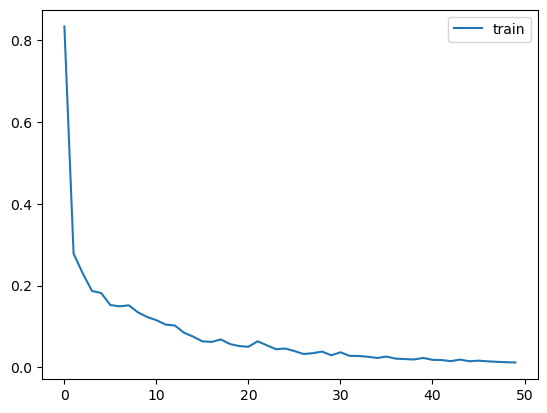

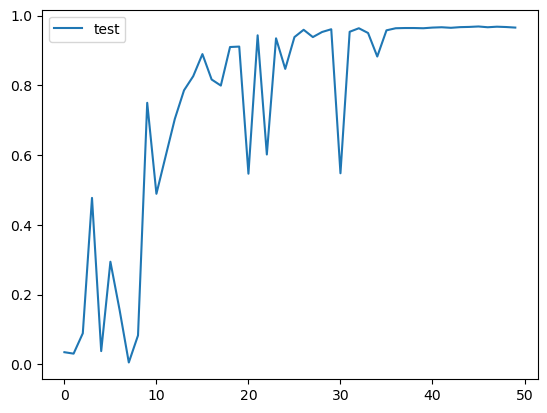

In [7]:
for i in range(epochs):
    loss_ep_train = 0
    pred_ep_train = 0
    
    loss_ep_test = 0
    pred_ep_test = 0
    model.train()
    
    for x, y in tqdm(trainloader):
#         with torch.autocast(device_type='cuda', dtype=torch.float16):
        coarsepred, pred = model(x.cuda())
        pred_err = loss_fn(pred, y.view(-1, 8).cuda())
        loss = loss_fn(coarsepred, y.view(-1, 8).cuda()) + coeff * pred_err
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()
        loss_ep_train += loss
        pred_ep_train += pred_err
    scheduler.step()
    
    model.eval()
#     for x, y in tqdm(testloader):
#         with torch.no_grad():
#             coarsepred, pred = model(x.cuda())
#             loss = loss_fn(coarsepred, y.view(-1, 8).cuda())
#             loss_ep_test += loss
#             pred_ep_test += loss_fn(pred, y.view(-1, 8).cuda())
            
    losses_train.append(loss_ep_train.item() / len(trainset))
#     losses_test.append(loss_ep_test.item() / len(testset))
    acc = eval_model(model, val_split)
    losses_test.append(acc)
    
    if acc > MAXACC:
        MAXACC = acc
        torch.save(model.state_dict(), '../../twostage.pkl')
        
    
    clear_output()
    print('pred fine', pred_ep_train.item() / len(trainset))#, 'pred_ep_test', pred_ep_test.item() / len(testset))
    print('loss train', loss_ep_train.item() / len(trainset))#, 'loss_ep_test', loss_ep_test.item() / len(testset))
    print('acc', acc, MAXACC)
    
    plt.plot(losses_train, label='train')
    plt.legend()
    plt.show()
    
    plt.plot(losses_test, label='test')
    plt.legend()
    plt.show()

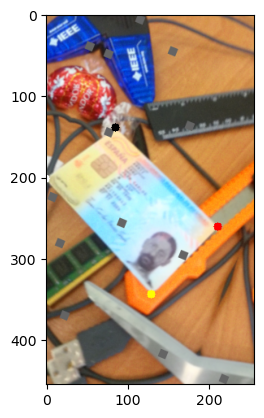

In [15]:
import cv2
x, y = next(iter(trainloader))
x = (np.array((x[0] * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)).permute(1, 2, 0)) * 255).astype(np.uint8)
H, W, C = x.shape
img = np.zeros((H, W, C)).astype(np.uint8)
img[:, :] = x
y = y[0] * torch.tensor([W, H]).view(1, 2)
for i, c in enumerate(y):
    img = cv2.circle(img, (int(c[0]), int(c[1])), 5, (255 * (i > 0), 255 * (i>1) , 255*(i > 2)), -1)
plt.imshow(img)

In [13]:
results_dict = dict()

for dp in tqdm(data_packs):
#     bcm = SimpleBaselineCrop(np.array(dp.template_item.image))
    for i in range(len(dp)):
        if dp[i].is_test_split():
            try:
                with torch.no_grad():
                    img = torch.tensor(aug_test(image=np.array(dp[i].image))['image']).permute(2, 0, 1).unsqueeze(0)
#                     pred = model(img.cuda())
                    coarsepred, pred = model(img.cuda())
#                     logits = model(img.cuda())
#                     pred = model.predict(logits)
#                 print(pred.shape)
                results_dict[dp[i].unique_key] = np.array(pred.cpu().detach().view(4, 2))
#                 print(np.array(pred.cpu().detach().view(4, 2)))

            except Exception as exc:
                # Для пропущенных в словаре ключей в метриках автоаматически засчитается IoU=0
                print(exc)

100%|███████████████████████████████████████████| 50/50 [03:34<00:00,  4.28s/it]


In [14]:
from course_ocr_t1.metrics import dump_results_dict, measure_crop_accuracy
dump_results_dict(results_dict, Path() / 'pred.json')
acc = measure_crop_accuracy(
    Path() / 'pred.json',
    Path() / 'gt.json'
)
print("Точность кропа: {:1.4f}".format(acc))

/opt/conda/lib/python3.7/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/conda/lib/python3.7/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


Точность кропа: 0.9402


/opt/conda/lib/python3.7/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/conda/lib/python3.7/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/conda/lib/python3.7/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/conda/lib/python3.7/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/conda/lib/python3.7/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/conda/lib/python3.7/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersect